In [2]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import hdbscan
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch
from openai import OpenAI
from dotenv import load_dotenv

# Set random seed for reproducibility
load_dotenv()
np.random.seed(42)

# Set matplotlib style
plt.style.use('seaborn')
sns.set_palette('husl')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.set_default_device(device)


Using device: cuda


C:\Users\83494\AppData\Local\Temp\ipykernel_36428\1080932920.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# Define embedding models
class BERTEmbedder:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.model = AutoModel.from_pretrained('bert-base-uncased')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        
    def get_embeddings(self, texts):
        embeddings = []
        for text in tqdm(texts, desc="BERT Embedding"):
            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(embedding)
        return np.array(embeddings)

class BGEEmbedder:
    def __init__(self):
        self.model = SentenceTransformer('BAAI/bge-large-en-v1.5')
        
    def get_embeddings(self, texts):
        return self.model.encode(texts)

class OpenAIEmbedder:
    def __init__(self, client):
        self.client = client
        
    def get_embeddings(self, texts):
        embeddings = []
        for text in tqdm(texts, desc="OpenAI Embedding"):
            response = self.client.embeddings.create(
                model="text-embedding-3-small",
                input=text
            )
            embeddings.append(response.data[0].embedding)
        return np.array(embeddings)

class E5Embedder:
    def __init__(self):
        self.model = SentenceTransformer('intfloat/e5-large-v2')
        
    def get_embeddings(self, texts):
        # Add query prefix for E5 model
        texts = [f"query: {text}" for text in texts]
        return self.model.encode(texts)

In [4]:
#  Data preparation and preprocessing
# Read data
df = pd.read_csv('../data/papers.csv')
print(f"Dataset size: {df.shape}")
print("\nData preview:")
df.head()

# Data cleaning and preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Remove special characters
    text = text.replace('\n', ' ').replace('\r', ' ')
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Apply preprocessing to 'summary' column instead of 'abstract'
df['processed_text'] = df['summary'].apply(preprocess_text)

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

Dataset size: (320, 8)

Data preview:
Training set size: (256, 9)
Test set size: (64, 9)


In [5]:
# Model evaluation
# Initialize embedders
embedders = {
    'BERT': BERTEmbedder(),
    'BGE': BGEEmbedder(),
    'OpenAI': OpenAIEmbedder(client),
    'E5': E5Embedder()
}

# Store evaluation results
results = {}

for model_name, embedder in embedders.items():
    print(f"\nEvaluating model: {model_name}")
    
    # Record start time
    start_time = time.time()
    
    # Get embeddings
    embeddings = embedder.get_embeddings(train_df['processed_text'].tolist())
    
    # Calculate time
    computation_time = time.time() - start_time
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(embeddings)
    
    # Perform clustering analysis
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings)
    
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    hdbscan_labels = hdbscan_clusterer.fit_predict(embeddings)
    
    # Calculate silhouette score
    silhouette_kmeans = silhouette_score(embeddings, kmeans_labels)
    
    # Use UMAP for dimensionality reduction
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)
    
    # Store results
    results[model_name] = {
        'embeddings': embeddings,
        'computation_time': computation_time,
        'similarity_matrix': similarity_matrix,
        'kmeans_labels': kmeans_labels,
        'hdbscan_labels': hdbscan_labels,
        'silhouette_score': silhouette_kmeans,
        'embedding_2d': embedding_2d
    }
    
    print(f"Computation time: {computation_time:.2f} seconds")
    print(f"Silhouette score: {silhouette_kmeans:.4f}")


Evaluating model: BERT


BERT Embedding:   0%|          | 0/256 [00:00<?, ?it/s]c:\Users\83494\anaconda3\envs\diff\lib\site-packages\torch\utils\_device.py:77: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return func(*args, **kwargs)
BERT Embedding: 100%|██████████| 256/256 [00:04<00:00, 61.36it/s]
c:\Users\83494\anaconda3\envs\diff\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\83494\anaconda3\envs\diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computation time: 4.18 seconds
Silhouette score: 0.0337

Evaluating model: BGE


c:\Users\83494\anaconda3\envs\diff\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\83494\anaconda3\envs\diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computation time: 5.95 seconds
Silhouette score: 0.0603

Evaluating model: OpenAI


OpenAI Embedding: 100%|██████████| 256/256 [01:21<00:00,  3.13it/s]
c:\Users\83494\anaconda3\envs\diff\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\83494\anaconda3\envs\diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computation time: 81.79 seconds
Silhouette score: 0.0445

Evaluating model: E5


c:\Users\83494\anaconda3\envs\diff\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\83494\anaconda3\envs\diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computation time: 5.84 seconds
Silhouette score: 0.0298


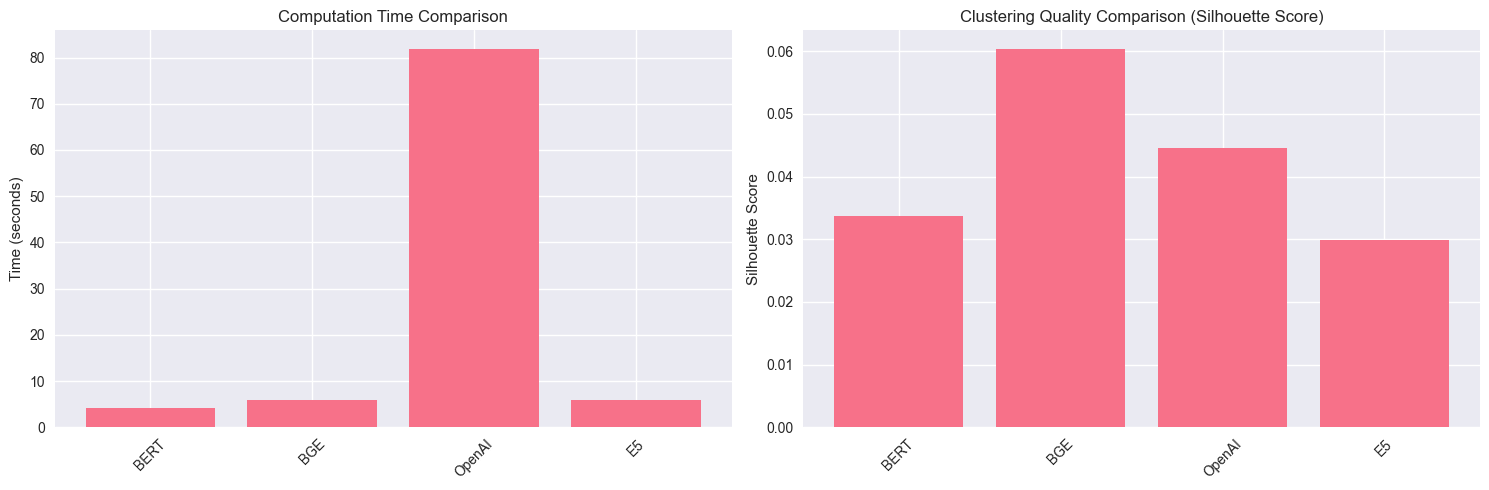

In [6]:
# Performance comparison visualization
def plot_performance_comparison(results):
    # Prepare data
    models = list(results.keys())
    times = [results[model]['computation_time'] for model in models]
    scores = [results[model]['silhouette_score'] for model in models]
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Computation time comparison
    ax1.bar(models, times)
    ax1.set_title('Computation Time Comparison')
    ax1.set_ylabel('Time (seconds)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Silhouette score comparison
    ax2.bar(models, scores)
    ax2.set_title('Clustering Quality Comparison (Silhouette Score)')
    ax2.set_ylabel('Silhouette Score')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot performance comparison
plot_performance_comparison(results)

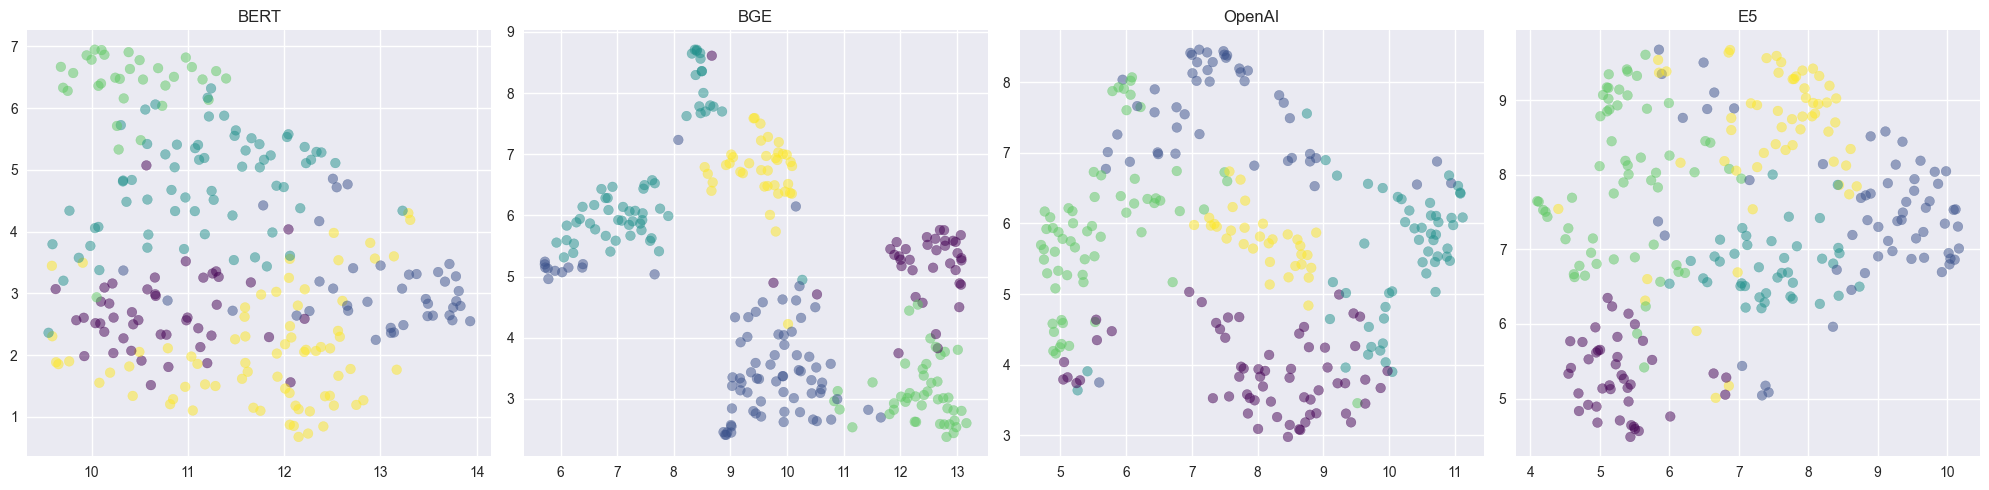

In [7]:
#  Embedding visualization
def plot_embeddings(results):
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
    
    for idx, (model_name, result) in enumerate(results.items()):
        embedding_2d = result['embedding_2d']
        labels = result['kmeans_labels']
        
        scatter = axes[idx].scatter(
            embedding_2d[:, 0],
            embedding_2d[:, 1],
            c=labels,
            cmap='viridis',
            alpha=0.5
        )
        axes[idx].set_title(model_name)
        
    plt.tight_layout()
    plt.show()

# Plot embedding visualization
plot_embeddings(results)

In [8]:
# Seventh cell: Detailed analysis
def analyze_embeddings(results):
    analysis = {}
    
    for model_name, result in results.items():
        embeddings = result['embeddings']
        
        # Calculate vector norms
        norms = np.linalg.norm(embeddings, axis=1)
        
        # Calculate variance
        variance = np.var(embeddings, axis=0)
        
        # Calculate sparsity
        sparsity = np.mean(embeddings == 0)
        
        analysis[model_name] = {
            'average_norm': np.mean(norms),
            'norm_std': np.std(norms),
            'variance_mean': np.mean(variance),
            'sparsity': sparsity
        }
    
    # Convert to DataFrame for better visualization
    analysis_df = pd.DataFrame(analysis).T
    return analysis_df

# Perform detailed analysis
analysis_results = analyze_embeddings(results)
print("\nDetailed Analysis Results:")
analysis_results


Detailed Analysis Results:


,average_norm,norm_std,variance_mean,sparsity
BERT,8.421299,2.993209e-01,0.009518,0.0
BGE,1.000000,4.148308e-08,0.000323,0.0
OpenAI,1.000000,3.205551e-08,0.000396,0.0
E5,1.000000,3.311110e-08,0.000161,0.0


In [10]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def visualize_all_embeddings(results_dict, categories, title="Comparison of Different Embedding Models"):
    """
    Create interactive 3D visualizations for multiple embedding models
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary containing results from different models
    categories : array-like
        Category labels for the data points
    title : str
        Main title for the visualization
    """
    # Create 2x2 subplots
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{'type': 'scene'}, {'type': 'scene'}],
               [{'type': 'scene'}, {'type': 'scene'}]],
        subplot_titles=list(results_dict.keys()),
        horizontal_spacing=0.05,
        vertical_spacing=0.05
    )
    
    # Define plot positions
    positions = [(1,1), (1,2), (2,1), (2,2)]
    
    # Reduce dimensions to 3D for each model
    reducer = umap.UMAP(n_components=3, random_state=42)
    
    # Add traces for each model
    for (model_name, model_results), pos in zip(results_dict.items(), positions):
        # Reduce to 3D
        embeddings_3d = reducer.fit_transform(model_results['embeddings'])
        
        # Create DataFrame for the current model
        df = pd.DataFrame({
            'Dimension 1': embeddings_3d[:, 0],
            'Dimension 2': embeddings_3d[:, 1],
            'Dimension 3': embeddings_3d[:, 2],
            'Category': categories
        })
        
        # Add scatter plot for each category
        for category in df['Category'].unique():
            mask = df['Category'] == category
            fig.add_trace(
                go.Scatter3d(
                    x=df[mask]['Dimension 1'],
                    y=df[mask]['Dimension 2'],
                    z=df[mask]['Dimension 3'],
                    mode='markers',
                    name=category,
                    showlegend=pos==(1,1),  # Only show legend for first plot
                    marker=dict(
                        size=5,
                        opacity=0.7
                    ),
                ),
                row=pos[0], col=pos[1]
            )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            y=0.95
        ),
        width=1400,
        height=1200,
        showlegend=True,
        legend=dict(
            title="Categories",
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    
    # Update scene properties for all subplots
    for i in range(1, 3):
        for j in range(1, 3):
            fig.update_scenes(
                dict(
                    xaxis=dict(backgroundcolor="rgb(245, 245, 255)", gridcolor="white", title="Dimension 1"),
                    yaxis=dict(backgroundcolor="rgb(245, 245, 255)", gridcolor="white", title="Dimension 2"),
                    zaxis=dict(backgroundcolor="rgb(245, 245, 255)", gridcolor="white", title="Dimension 3"),
                ),
                row=i, col=j
            )

    return fig

# Create visualization using existing results
fig = visualize_all_embeddings(
    results,  # Using the existing results dictionary
    categories=train_df['category'],
    title="Comparison of Different Embedding Models"
)

# Show the plot
fig.show()

# Print evaluation metrics for each model
print("\nModel Evaluation Metrics:")
print("-" * 50)
for model_name, model_results in results.items():
    print(f"\n{model_name}:")
    print(f"Computation time: {model_results['computation_time']:.2f} seconds")
    print(f"Silhouette score: {model_results['silhouette_score']:.4f}")

c:\Users\83494\anaconda3\envs\diff\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Model Evaluation Metrics:
--------------------------------------------------

BERT:
Computation time: 4.18 seconds
Silhouette score: 0.0337

BGE:
Computation time: 5.95 seconds
Silhouette score: 0.0603

OpenAI:
Computation time: 81.79 seconds
Silhouette score: 0.0445

E5:
Computation time: 5.84 seconds
Silhouette score: 0.0298
